# DaniO5P CNN training and evaluation

This notebook trains and evaluates an ensemble of convolutional neural networks (CNN). These models take an input sequence and generate predictions of $log_2MRL^{t_i}$ for every timepoint $t_i$, and $Δlog_2X^{t_i - t_{i-1}}$ for every time interval $t_i - t_{i-1}$, for a total of 8 outputs.

Note that the predicted quantities are the *residuals* from the length model and not the actual measurements. To obtain a full prediction on measured quantities, CNN predictions must be added to length model predictions.

Models are trained in a 10-fold cross validation scheme based on chromosome splits: sequences from different chromosomes are used for either training/validation/testing of each model, and every chromosome is in the test set of exactly one model. Chromosome splits are generated in `generate_chr_splits.ipynb`.

After training, predictions are made on the test set of each model and saved to `Zb_5UTR_MPRA_cnn_test_predictions.tsv.gz`. $r^2$ are calculated based on these predictions and saved to `performance_cnn_test_r2.csv`. Finally, predictions are made using the full ensemble (average output of all models) and saved to `Zb_5UTR_MPRA_cnn_ensemble_predictions.tsv.gz`.

In [1]:
import json
import os
import sys

import numpy
import matplotlib
from matplotlib import pyplot
import pickle
import pandas
import scipy
import seaborn
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import models

utils_dir = '../utils'
sys.path.append(utils_dir)
import custom_plots
import seq_utils
import cnn_vgg

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Arial'

# Read data

In [3]:
timepoint_list = [2, 4, 6, 10]

lib_tpm_col = 'TPM_library'
log2_lib_tpm_col = 'log2_TPM_library'

log2_mrl_cols = [f'log2_MRL_{t}hpf' for t in timepoint_list]
delta_log2_x_cols = [f'Δlog2_X_{t}hpf' for t in timepoint_list]

res_log2_mrl_cols = [f'res_log2_MRL_{t}hpf' for t in timepoint_list]
res_delta_log2_x_cols = [f'res_Δlog2_X_{t}hpf' for t in timepoint_list]

log2_x_cols = [f'log2_X_{t}hpf' for t in timepoint_list]

In [4]:
# Load data
data_full = pandas.read_csv(
    '../preprocess_data/Zb_5UTR_MPRA_preprocessed.tsv.gz',
    index_col=0,
    sep='\t',
)
# Add residuals
data_residuals = pandas.read_csv(
    '../length_model/Zb_5UTR_MPRA_len_residuals.tsv.gz',
    index_col=0,
    sep='\t',
)
data_full = pandas.concat([data_full, data_residuals], axis=1)

data_full

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,MRL_10hpf,log2_MRL_10hpf,res_log2_MRL_2hpf,res_log2_MRL_4hpf,res_log2_MRL_6hpf,res_log2_MRL_10hpf,res_Δlog2_X_2hpf,res_Δlog2_X_4hpf,res_Δlog2_X_6hpf,res_Δlog2_X_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103.0,103.0,2.0,52.427184,23.9,20318.0,20318,...,6.480393,2.696081,-1.399931,-1.088321,-0.755253,-0.941045,0.501695,-0.076781,-0.174912,-0.216314
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134.0,134.0,0.0,61.940299,35.3,72681.0,72681,...,4.441558,2.151066,-0.683110,-0.525705,-0.089619,-0.524812,0.421512,0.006283,-0.097622,-0.209622
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178.0,178.0,1.0,46.629213,30.1,27446.0,27446,...,6.260806,2.646348,-0.018686,0.774950,0.120307,0.886358,-0.027497,-0.328324,0.513155,-0.312300
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152.0,152.0,0.0,46.052632,26.1,113092.0,113092,...,9.108052,3.187143,0.982463,0.745786,0.532694,0.949547,-0.299779,0.069061,0.113203,0.558087
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153.0,153.0,1.0,47.058824,31.8,20320.0,20320,...,4.903643,2.293854,-0.020768,-0.055346,0.141463,0.078025,0.112564,-0.032827,0.037401,0.143177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000025554_ENSDART00000103273_1746_wdr83os_27060,chr11,+,wdr83os,126.0,126.0,1.0,37.301587,22.8,27060.0,27060,...,20.048542,4.325425,-0.104439,0.456420,-0.230639,1.426489,0.074387,-0.079539,0.382409,-0.250690
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111.0,111.0,2.0,34.234234,12.5,86762.0,86762,...,12.727341,3.669859,-0.077696,-0.171766,-0.396709,0.305802,-1.325557,0.226216,0.101824,-0.613514
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305.0,197.0,4.0,31.979695,25.9,21263.6,21263,...,7.074025,2.822531,1.327407,1.750233,1.345226,1.295368,-1.734546,-0.290205,0.650032,-0.311490
ENSDARG00000056892_ENSDART00000148517_5556_mpp6a_23746.2,chr16,-,mpp6a,311.0,161.0,1.0,39.130435,37.6,23746.2,23746,...,16.071784,4.006458,1.001961,1.058925,1.405726,1.954980,-1.236349,-0.194121,0.115763,0.074736


In [5]:
# Used later for one-hot encoding
max_seq_len = int(data_full['insert_length'].max())

In [6]:
# Preserve only rows with input tpm above threshold
tpm_threshold = 3
data = data_full[data_full[lib_tpm_col] > tpm_threshold]
print(f"{len(data_full):,} total sequences, {len(data):,} retained.")
data

18,021 total sequences, 17,951 retained.


,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,MRL_10hpf,log2_MRL_10hpf,res_log2_MRL_2hpf,res_log2_MRL_4hpf,res_log2_MRL_6hpf,res_log2_MRL_10hpf,res_Δlog2_X_2hpf,res_Δlog2_X_4hpf,res_Δlog2_X_6hpf,res_Δlog2_X_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103.0,103.0,2.0,52.427184,23.9,20318.0,20318,...,6.480393,2.696081,-1.399931,-1.088321,-0.755253,-0.941045,0.501695,-0.076781,-0.174912,-0.216314
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134.0,134.0,0.0,61.940299,35.3,72681.0,72681,...,4.441558,2.151066,-0.683110,-0.525705,-0.089619,-0.524812,0.421512,0.006283,-0.097622,-0.209622
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178.0,178.0,1.0,46.629213,30.1,27446.0,27446,...,6.260806,2.646348,-0.018686,0.774950,0.120307,0.886358,-0.027497,-0.328324,0.513155,-0.312300
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152.0,152.0,0.0,46.052632,26.1,113092.0,113092,...,9.108052,3.187143,0.982463,0.745786,0.532694,0.949547,-0.299779,0.069061,0.113203,0.558087
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153.0,153.0,1.0,47.058824,31.8,20320.0,20320,...,4.903643,2.293854,-0.020768,-0.055346,0.141463,0.078025,0.112564,-0.032827,0.037401,0.143177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000060397_ENSDART00000085051_231_hhip_26758.1,chr1,+,hhip,410.0,209.0,2.0,31.578947,26.3,26758.1,26758,...,10.805940,3.433753,0.676288,0.570357,-0.253157,2.003083,-2.630054,-0.050688,0.934457,-1.030281
ENSDARG00000098284_ENSDART00000170620_10459_ctxn1_29429.4,chr22,+,ctxn1,678.0,174.0,0.0,51.724138,41.2,29429.4,29429,...,24.531388,4.616557,1.482921,1.453752,1.322473,2.795048,-2.494435,-0.184354,0.678807,-0.851463
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111.0,111.0,2.0,34.234234,12.5,86762.0,86762,...,12.727341,3.669859,-0.077696,-0.171766,-0.396709,0.305802,-1.325557,0.226216,0.101824,-0.613514
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305.0,197.0,4.0,31.979695,25.9,21263.6,21263,...,7.074025,2.822531,1.327407,1.750233,1.345226,1.295368,-1.734546,-0.290205,0.650032,-0.311490


Text(0, 0.5, 'Minimum TPM per sequence')

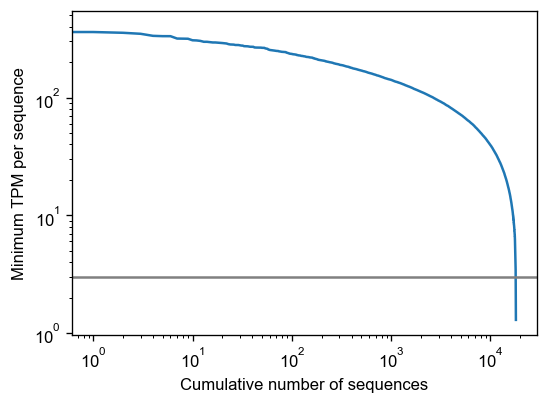

In [7]:
# Plot number of sequences vs. TPM theshold
data_tpm_min = data_full[lib_tpm_col].sort_values(ascending=False)

f, ax = pyplot.subplots(figsize=(5, 3.5))
ax.plot(range(len(data_tpm_min)), data_tpm_min)
ax.axhline(tpm_threshold, color='gray')
ax.set_xscale('log')
ax.set_xlabel('Cumulative number of sequences')
ax.set_yscale('log')
ax.set_ylabel('Minimum TPM per sequence')

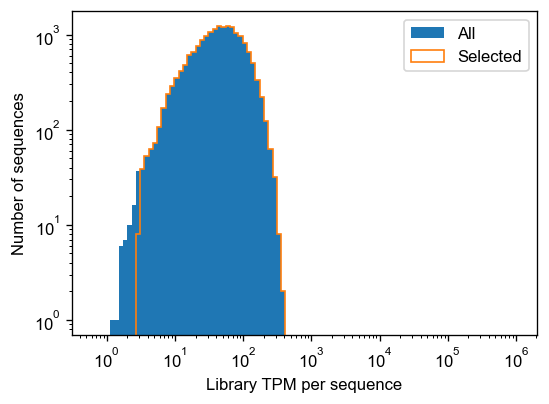

In [8]:
# Plot histogram with number of reads
pyplot.figure(figsize=(5, 3.5))
pyplot.hist(
    data_full[lib_tpm_col],
    bins=numpy.logspace(-0.2, 6, 100),
    log=True,
    label='All')
pyplot.hist(
    data[lib_tpm_col],
    bins=numpy.logspace(-0.2, 6, 100),
    log=True,
    label='Selected',
    histtype='step')
pyplot.xscale('log')
pyplot.xlabel('Library TPM per sequence')
pyplot.ylabel('Number of sequences')
pyplot.legend()

# Load split info

Produced by the `generate_chr_splits.ipynb` notebook.

In [9]:
with open('chr_splits.json', 'r') as f:
    chr_splits_info = json.load(f)
# chr_splits_info

# Train ensemble model

In [10]:
# Folder for model files
models_dir = 'models_cnn_vgg'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [11]:
# Bootstrapping loop
epochs = 100
batch_size = 128
learning_rate = 3e-4

for split_idx, chr_split_info in enumerate(chr_splits_info):
    print(f"Training model {split_idx + 1}/{len(chr_splits_info)}...")

    # Split data
    train_chrs = chr_split_info['train']
    val_chrs = chr_split_info['val']
    test_chrs = chr_split_info['test']

    data_train = data[data['chr'].isin(train_chrs)]
    data_val = data[data['chr'].isin(val_chrs)]
    data_test = data[data['chr'].isin(test_chrs)]

    print(f"{len(data_train):,} samples for training, {len(data_val):,} for validation, {len(data_test):,} for testing...")

    model = cnn_vgg.make_model(
        input_seq_len=max_seq_len,
        conv_layers=3,
        conv_kernel_size=7,
        conv_activation='relu',
        conv_filters_first=128,
        conv_dropout=0.1,
        dense_units=[150],
        dense_activation=['relu'],
        dense_dropout=[0.0],
        n_outputs=len(res_log2_mrl_cols + res_delta_log2_x_cols),
        layer_name_suffix=f'_chr_split_{split_idx:03d}',
    )

    # model.summary()

    # Extract input, output in the preferred format for model
    data_train_x = seq_utils.one_hot_encode(data_train['insert_seq'], max_seq_len=max_seq_len, padding='right', mask_val=0)
    data_train_y = data_train[res_log2_mrl_cols + res_delta_log2_x_cols].values

    data_val_x = seq_utils.one_hot_encode(data_val['insert_seq'], max_seq_len=max_seq_len, padding='right', mask_val=0)
    data_val_y = data_val[res_log2_mrl_cols + res_delta_log2_x_cols].values

    # Use Adam optimizer with decayed learning rate
    # lr = initial_lr / (1 + decay_rate * step / decay_step)
    # At 10 epochs, lr is 1/2 of initial
    # At 20 epochs, lr is 1/3 of initial
    # At 30 epochs, lr is 1/4 of initial
    lr_schedule = tensorflow.keras.optimizers.schedules.InverseTimeDecay(
        learning_rate,
        decay_steps=len(data_train)/batch_size*10,
        decay_rate=1,
        staircase=False,
    )
    optimizer = tensorflow.keras.optimizers.Adam(lr_schedule)

    # Callback: stop training after no improvement in validation
    callbacks = [
        tensorflow.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
        ),
    ]

    # custom loss function
    # weights from standard deviation of model outputs
    data_train_y_std = data_train_y.std(axis=0)
    w = 1 / data_train_y_std
    w = numpy.expand_dims(w, axis=0)
    def custom_loss(y_true, y_pred):
        se = tensorflow.square(y_true - y_pred)
        mse = tensorflow.reduce_mean(se, axis=0)
        return tensorflow.reduce_mean(mse * w)
    
    model.compile(loss=custom_loss, optimizer=optimizer)
    # model.compile(loss='mean_squared_error', optimizer=optimizer)

    # Train
    training_history = model.fit(
        data_train_x,
        data_train_y,
        validation_data=(data_val_x, data_val_y),
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        callbacks=callbacks,
        verbose=1,
    )

    # Save model
    model_path = os.path.join(models_dir, f'model_{split_idx:03d}.h5')
    model.save(model_path, save_traces=False, include_optimizer=False)
    print(f"Model saved to {model_path}.")
        
    # Save training loss plot
    fig, ax = pyplot.subplots(1, 1, figsize=(4, 4))
    n_epochs_actual = len(training_history.history['loss'])
    ax.plot(
        numpy.arange(1, n_epochs_actual + 1),
        training_history.history['loss'],
        marker='o',
        label='Training',
    )
    ax.plot(
        numpy.arange(1, n_epochs_actual + 1),
        training_history.history['val_loss'],
        marker='o',
        label='Validation',
    )
    ax.set_yscale('log')
    ax.set_ylim(0.01, 1)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    fig.savefig(os.path.join(models_dir, f'model_{split_idx:03d}_training.png'), dpi=200, bbox_inches='tight')
    pyplot.close(fig)

    print(f"Done with model {split_idx + 1}/{len(chr_splits_info)}.")
    print()
        
print("Done.")

Training model 1/10...
14,722 samples for training, 1,595 for validation, 1,634 for testing...
Epoch 1/100
116/116 [==============================] - 13s 52ms/step - loss: 0.4437 - val_loss: 0.4815
Epoch 2/100
116/116 [==============================] - 5s 47ms/step - loss: 0.4127 - val_loss: 0.4094
Epoch 3/100
116/116 [==============================] - 5s 47ms/step - loss: 0.3768 - val_loss: 0.5325
Epoch 4/100
116/116 [==============================] - 5s 47ms/step - loss: 0.3344 - val_loss: 0.3247
Epoch 5/100
116/116 [==============================] - 5s 47ms/step - loss: 0.2889 - val_loss: 0.3778
Epoch 6/100
116/116 [==============================] - 5s 47ms/step - loss: 0.2706 - val_loss: 0.3282
Epoch 7/100
116/116 [==============================] - 5s 47ms/step - loss: 0.2573 - val_loss: 0.3447
Epoch 8/100
116/116 [==============================] - 6s 48ms/step - loss: 0.2540 - val_loss: 0.3199
Epoch 9/100
116/116 [==============================] - 6s 48ms/step - loss: 0.2476 - val

# Make average model

In [12]:
# Input
model_input = layers.Input(shape=(None, 4))
model_list = []
model_outputs = []

# Load models
for split_idx, chr_split_info in enumerate(chr_splits_info):
    model_path = os.path.join(models_dir, f'model_{split_idx:03d}.h5')
    
    model = cnn_vgg.load_model(model_path)
    model_list.append(model)
    
    model_output = model(model_input)
    model_outputs.append(model_output)
    
# Model output: average of bs model outputs
model_bs_output = layers.Average()(model_outputs)

# Define bootstrapped model
model_bs = models.Model(
    model_input,
    model_bs_output,
)
model_bs.save(os.path.join(models_dir, f'model_avg.h5'), save_traces=False, include_optimizer=False)

c:\Users\casti\miniconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Evaluate models

To get precise performance metrics, evaluation is run on a held-out test dataset which is different for each of the 10 models. These are reported in Figure 5.

In [11]:
# Load models
model_list = []
for split_idx, chr_split_info in enumerate(chr_splits_info):
    model_path = os.path.join(models_dir, f'model_{split_idx:03d}.h5')
    
    model = cnn_vgg.load_model(model_path)
    model_list.append(model)
    
model_list

In [12]:
# Add CNN predictions to data table
# For each model, predict only on its test set given by its chromosomal split
# Compute performance metrics too

r2_list = []

for split_idx, chr_split_info in enumerate(chr_splits_info):
    print(f"Evaluating model trained on data split {split_idx}...")

    # Select data from test chromosomes
    test_chrs = chr_split_info['test']
    data_test = data[data['chr'].isin(test_chrs)]

    data_test_x = seq_utils.one_hot_encode(data_test['insert_seq'], max_seq_len=max_seq_len, padding='right', mask_val=0)
    data_test_y = data_test[res_log2_mrl_cols + res_delta_log2_x_cols].values

    # Load model and generate prediction
    model = model_list[split_idx]
    data_test_y_pred = model.predict(data_test_x)
    
    # Add to dataframe
    for output_idx, output_name in enumerate(log2_mrl_cols + delta_log2_x_cols):
        data.loc[data_test.index, 'pred_cnn_test_' + output_name] = data_test_y_pred[:, output_idx]

    # Calculate r^2 on each output
    r2_outputs_list = []
    for output_idx, output_label in enumerate(res_log2_mrl_cols + res_delta_log2_x_cols):
        # Calculate overall R^2
        lrres = scipy.stats.linregress(
            data_test_y[:, output_idx],
            data_test_y_pred[:, output_idx],
        )
        r2_outputs_list.append(lrres.rvalue**2)
    r2_list.append(r2_outputs_list)

r2_test_df = pandas.DataFrame(r2_list, columns=res_log2_mrl_cols + res_delta_log2_x_cols)
r2_test_df

Evaluating model trained on data split 0...


C:\Users\casti\AppData\Local\Temp\ipykernel_12444\1045182067.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data_test.index, 'pred_cnn_test_' + output_name] = data_test_y_pred[:, output_idx]
C:\Users\casti\AppData\Local\Temp\ipykernel_12444\1045182067.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data_test.index, 'pred_cnn_test_' + output_name] = data_test_y_pred[:, output_idx]
C:\Users\casti\AppData\Local\Temp\ipykernel_12444\1045182067.py:23: SettingWithCopyWarning: 
A value

Evaluating model trained on data split 1...
Evaluating model trained on data split 2...
Evaluating model trained on data split 3...
Evaluating model trained on data split 4...
Evaluating model trained on data split 5...
Evaluating model trained on data split 6...
Evaluating model trained on data split 7...
Evaluating model trained on data split 8...
Evaluating model trained on data split 9...


,res_log2_MRL_2hpf,res_log2_MRL_4hpf,res_log2_MRL_6hpf,res_log2_MRL_10hpf,res_Δlog2_X_2hpf,res_Δlog2_X_4hpf,res_Δlog2_X_6hpf,res_Δlog2_X_10hpf
0,0.532883,0.465085,0.445644,0.562447,0.374473,0.343456,0.377498,0.388249
1,0.508218,0.418427,0.439829,0.505859,0.424098,0.346844,0.274918,0.376143
2,0.523945,0.494329,0.476025,0.542091,0.427768,0.366006,0.306553,0.380224
3,0.416329,0.361474,0.366605,0.524620,0.354878,0.320028,0.339880,0.378159
4,0.501264,0.428005,0.423680,0.543683,0.359344,0.350505,0.314010,0.381911
5,0.518675,0.410917,0.426853,0.526435,0.361147,0.293757,0.328604,0.369485
6,0.500892,0.447494,0.438608,0.496615,0.341978,0.369640,0.337279,0.402772
7,0.500114,0.440422,0.441074,0.537030,0.362625,0.347011,0.336825,0.392246
8,0.470885,0.396408,0.407349,0.481881,0.360535,0.381113,0.328816,0.384396
9,0.499481,0.416403,0.410424,0.509504,0.325384,0.346051,0.340324,0.337583


In [13]:
# Save performance metrics
r2_test_df.to_csv('performance_cnn_test_r2.csv')
r2_test_df

,res_log2_MRL_2hpf,res_log2_MRL_4hpf,res_log2_MRL_6hpf,res_log2_MRL_10hpf,res_Δlog2_X_2hpf,res_Δlog2_X_4hpf,res_Δlog2_X_6hpf,res_Δlog2_X_10hpf
0,0.532883,0.465085,0.445644,0.562447,0.374473,0.343456,0.377498,0.388249
1,0.508218,0.418427,0.439829,0.505859,0.424098,0.346844,0.274918,0.376143
2,0.523945,0.494329,0.476025,0.542091,0.427768,0.366006,0.306553,0.380224
3,0.416329,0.361474,0.366605,0.524620,0.354878,0.320028,0.339880,0.378159
4,0.501264,0.428005,0.423680,0.543683,0.359344,0.350505,0.314010,0.381911
5,0.518675,0.410917,0.426853,0.526435,0.361147,0.293757,0.328604,0.369485
6,0.500892,0.447494,0.438608,0.496615,0.341978,0.369640,0.337279,0.402772
7,0.500114,0.440422,0.441074,0.537030,0.362625,0.347011,0.336825,0.392246
8,0.470885,0.396408,0.407349,0.481881,0.360535,0.381113,0.328816,0.384396
9,0.499481,0.416403,0.410424,0.509504,0.325384,0.346051,0.340324,0.337583


In [14]:
residual_axis_limits = [
    (-3.5, 3), # log2_MRL
    (-4, 4), # Δlog2_MRL
    (-3, 3), # Δlog2_X
    (-4, 4), # log2_X
]

In [15]:
# Plot performance per ensemble member
for split_idx, chr_split_info in enumerate(chr_splits_info):
    print(f"Evaluating model trained on data split {split_idx}...")

    # Select data from test chromosomes
    test_chrs = chr_split_info['test']
    data_test = data[data['chr'].isin(test_chrs)]
    
    # Plot
    fig = custom_plots.plot_pred_vs_obs(
        data_test,
        obs_col_prefix='res',
        pred_col_prefix='pred_cnn_test',
        axis_limits=residual_axis_limits,
    )

    fig.savefig(os.path.join(models_dir, f'model_{split_idx:03d}_performance.png'), dpi=200, bbox_inches='tight')
    fig.savefig(os.path.join(models_dir, f'model_{split_idx:03d}_performance.svg'), dpi=200, bbox_inches='tight')
    pyplot.close(fig)

Evaluating model trained on data split 0...
Evaluating model trained on data split 1...
Evaluating model trained on data split 2...
Evaluating model trained on data split 3...
Evaluating model trained on data split 4...
Evaluating model trained on data split 5...
Evaluating model trained on data split 6...
Evaluating model trained on data split 7...
Evaluating model trained on data split 8...
Evaluating model trained on data split 9...


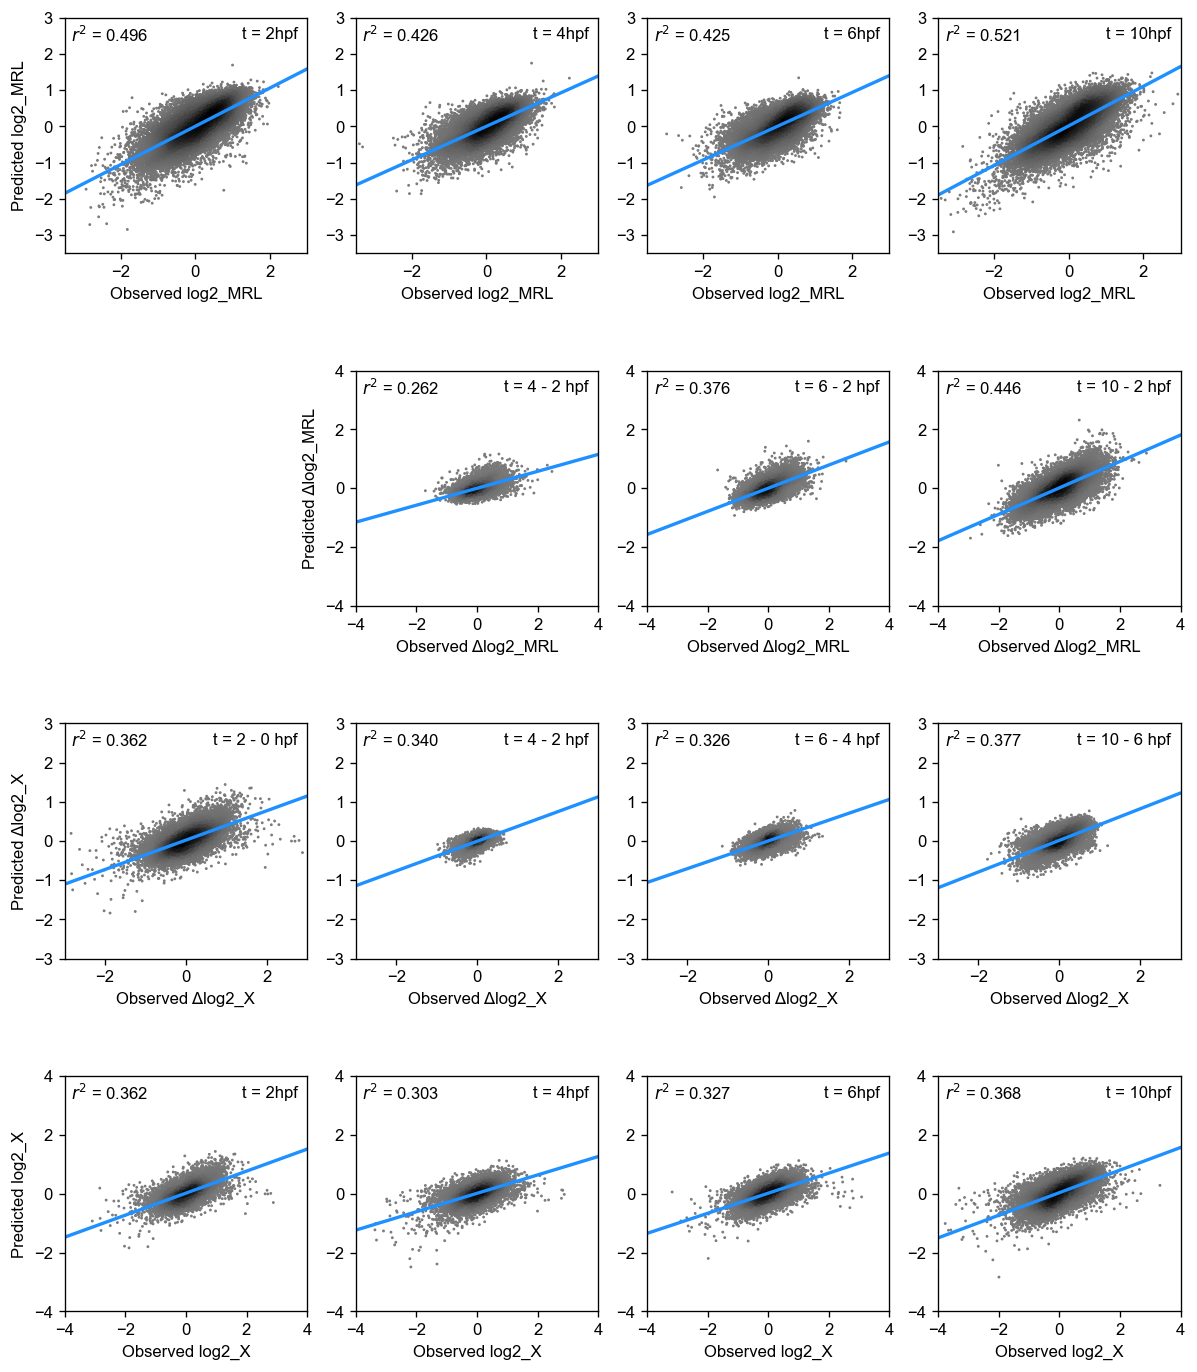

In [16]:
# Combined performance of all models in their test sets
fig = custom_plots.plot_pred_vs_obs(
        data,
        obs_col_prefix='res',
        pred_col_prefix='pred_cnn_test',
        axis_limits=residual_axis_limits,
)

fig.savefig(os.path.join(models_dir, f'model_all_test_performance.png'), dpi=200, bbox_inches='tight')
fig.savefig(os.path.join(models_dir, f'model_all_test_performance.svg'), dpi=200, bbox_inches='tight')

In [17]:
# Save CNN predictions on the test set
data_pred_cnn_test = data[['pred_cnn_test_' + c for c in log2_mrl_cols + delta_log2_x_cols]]
data_pred_cnn_test.to_csv('Zb_5UTR_MPRA_cnn_test_predictions.tsv.gz', sep='\t', compression='gzip')
data_pred_cnn_test

,pred_cnn_test_log2_MRL_2hpf,pred_cnn_test_log2_MRL_4hpf,pred_cnn_test_log2_MRL_6hpf,pred_cnn_test_log2_MRL_10hpf,pred_cnn_test_Δlog2_X_2hpf,pred_cnn_test_Δlog2_X_4hpf,pred_cnn_test_Δlog2_X_6hpf,pred_cnn_test_Δlog2_X_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,-1.293906,-1.081233,-1.118220,-1.247082,0.300244,-0.164849,-0.102279,-0.539334
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,-0.444051,-0.112083,-0.066859,-0.227000,0.323338,-0.177232,0.017116,-0.025471
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,0.383577,0.606560,0.555624,0.741050,0.384909,-0.076002,0.091336,0.129174
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,0.635544,0.407351,0.446237,0.390184,-0.099457,-0.045970,0.118227,0.288848
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,-0.167644,0.189465,0.104203,0.267131,-0.182496,-0.065697,0.157745,-0.070825
...,...,...,...,...,...,...,...,...
ENSDARG00000060397_ENSDART00000085051_231_hhip_26758.1,-0.284998,-0.424335,-0.603491,-0.376997,-0.211514,-0.089646,-0.109184,0.052361
ENSDARG00000098284_ENSDART00000170620_10459_ctxn1_29429.4,0.370130,0.501741,0.327186,0.625036,-1.078609,-0.568283,0.472315,-0.093756
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,-0.072929,0.013312,0.025958,-0.114593,-0.101098,0.149082,0.011946,-0.211938
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,0.669225,0.837168,0.619508,0.661890,-0.894918,-0.449572,0.485773,-0.458338


# Generate model ensemble predictions

Here we generate predictions for all sequences using the average of the individual model outputs. These are not used to compute reported metrics but are used later when doing model interpretation and analysis.

In [18]:
# Add ensemble predictions
data_x = seq_utils.one_hot_encode(data['insert_seq'], max_seq_len=max_seq_len, padding='right', mask_val=0)

model_preds = []
for model_idx, model in enumerate(model_list):
    data_y_pred = model.predict(data_x)
    model_preds.append(data_y_pred)

# Average predictions
data_y_pred = numpy.mean(model_preds, axis=0)

# Add to dataframe
for output_idx, output_name in enumerate(log2_mrl_cols + delta_log2_x_cols):
    data['pred_cnn_ens_' + output_name] = data_y_pred[:, output_idx]

C:\Users\casti\AppData\Local\Temp\ipykernel_12444\3317718904.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred_cnn_ens_' + output_name] = data_y_pred[:, output_idx]
C:\Users\casti\AppData\Local\Temp\ipykernel_12444\3317718904.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred_cnn_ens_' + output_name] = data_y_pred[:, output_idx]
C:\Users\casti\AppData\Local\Temp\ipykernel_12444\3317718904.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

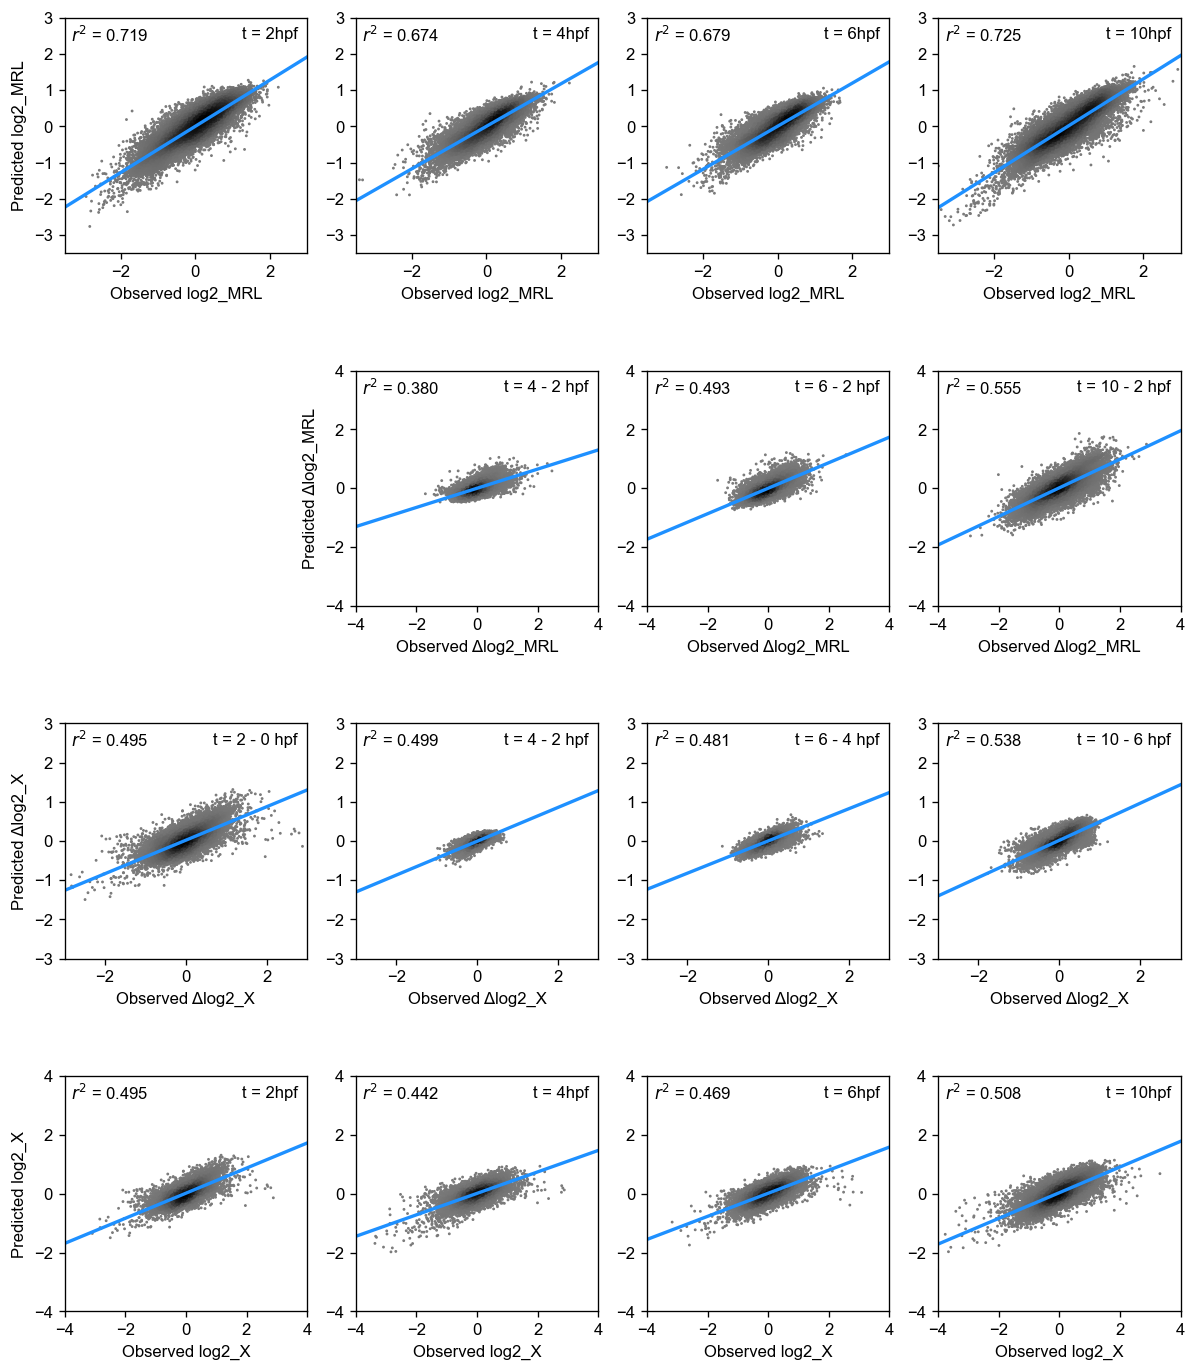

In [19]:
# Plot ensemble model performance
fig = custom_plots.plot_pred_vs_obs(
        data,
        obs_col_prefix='res',
        pred_col_prefix='pred_cnn_ens',
        axis_limits=residual_axis_limits,
)

fig.savefig(f'model_cnn_ensemble_performance.png', dpi=200, bbox_inches='tight')
fig.savefig(f'model_cnn_ensemble_performance.svg', dpi=200, bbox_inches='tight')

In [20]:
# Save spreadsheet with predictions
data_pred_cnn_ens = data[['pred_cnn_ens_' + c for c in log2_mrl_cols + delta_log2_x_cols]]
data_pred_cnn_ens.to_csv('Zb_5UTR_MPRA_cnn_ensemble_predictions.tsv.gz', sep='\t', compression='gzip')